In [0]:
# Data Processing and Cleaning
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

#Miscellaneous
from tqdm import tqdm_notebook

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [72]:

#((pd.DataFrame(train.isnull().sum()).T)/len(train))*100
#print(pd.DataFrame(test.isnull().sum()).T )

"""
train:
7 feats with no genre
8 with no overview
156 without prod com
2 without runtime
276 witout kewrods
13 without cast
16 without crew

test:
16 genre
14 overview
258 prod coms
4 runtime
393 keywords
13 cast
22 crew
"""

pd.DataFrame(test.budget.value_counts()).T


,0,20000000,25000000,15000000,10000000,30000000,40000000,5000000,35000000,50000000,6000000,12000000,3000000,60000000,18000000,4000000,2000000,8000000,70000000,45000000,7000000,1000000,80000000,11000000,14000000,17000000,3500000,9000000,2500000,75000000,22000000,150000000,13000000,55000000,28000000,100000000,16000000,19000000,24000000,6500000,...,9272437,10700000,1103000,17700000,15774948,176000003,4357373,243000,6600000,923000,1920000,27563396,325000,2280000,620000,30250000,1750000,2224000,22500000,26350000,450,139000000,26500000,36500000,16000,103000,58800000,13800000,103000000,707503,439000,5600000,8256269,14800000,8000,947000,390000,2479000,11097000,291000
budget,1211,116,104,100,94,91,73,72,70,68,68,64,61,54,54,54,51,46,46,44,43,42,38,36,36,36,34,33,33,32,32,31,31,31,30,27,27,24,23,22,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


(array([976., 287., 192., 164., 119.,  96.,  76.,  71.,  60.,  56.,  45.,
         51.,  30.,  39.,  31.,  38.,  27.,  34.,  31.,  28.,  28.,  20.,
         19.,  26.,  13.,  13.,  19.,  13.,   8.,  22.,  18.,  18.,  16.,
          8.,  10.,   9.,  10.,  10.,   9.,   5.,   9.,   8.,   8.,   7.,
          7.,   7.,   5.,   5.,   8.,   7.,   5.,   3.,   5.,   1.,   5.,
          2.,   5.,   1.,   3.,   4.,   2.,   7.,   2.,   2.,   2.,   7.,
          2.,   0.,   5.,   6.,   5.,   5.,   2.,   8.,   1.,   2.,   1.,
          3.,   1.,   1.,   4.,   2.,   2.,   1.,   1.,   2.,   0.,   2.,
          1.,   0.,   3.,   1.,   2.,   3.,   0.,   0.,   0.,   0.,   2.,
          1.,   0.,   0.,   1.,   0.,   1.,   2.,   0.,   1.,   2.,   0.,
          1.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   1.,   1.,   2.,
          1.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,   2.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   2.,   2.,   0.,
          0.,   0.,   0.,   0.,   1., 

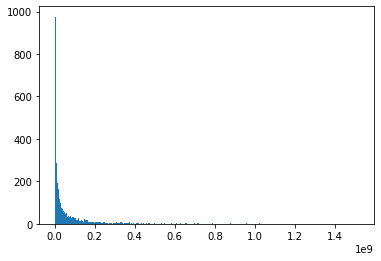

In [88]:
plt.hist(train.revenue, bins = 300)

TypeError: ignored

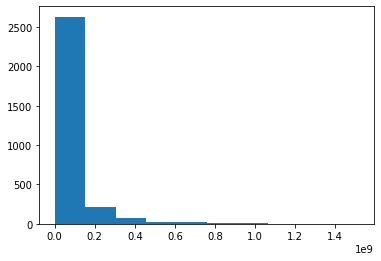

In [75]:
train['revenue'] = np.log1p(train['revenue'])


In [0]:
rf_cols = ['budget', 'status', 'homepage','original_language', 'release_date', 'runtime', 'revenue']
rf_train = train[rf_cols].copy()
rf_cols.remove('revenue')
rf_test = test[rf_cols].copy()

In [0]:
median_budget = rf_train[rf_train['budget'] > 0]['budget'].median()
def fill_budget(df, median_budget):
    df['budget_is_median'] = 0
    df.loc[df.budget == 0, 'budget_is_median'] = 1
    df.loc[df.budget == 0, 'budget'] = median_budget
    return df

rf_train = fill_budget(rf_train, median_budget)
rf_test = fill_budget(rf_test, median_budget)

In [0]:
rf_combined = pd.concat([rf_train, rf_test], sort=False)
le = LabelEncoder()
le.fit(rf_combined['original_language'])
rf_train['original_language'] = le.transform(rf_train['original_language'])
rf_test['original_language'] = le.transform(rf_test['original_language'])

In [0]:
rf_test.loc[rf_test['status'].isnull() == True, 'status'] = 'Released'
rf_combined.loc[rf_combined['status'].isnull() == True, 'status'] = 'Released'
le = LabelEncoder()
le.fit(rf_combined['status'])
rf_train['status'] = le.transform(rf_train['status'])
rf_test['status'] = le.transform(rf_test['status'])

In [0]:
rf_train.loc[rf_train['homepage'].isnull() == True, 'homepage'] = 0
rf_train.loc[rf_train['homepage'].isnull() == False, 'homepage'] = 1

rf_test.loc[rf_test['homepage'].isnull() == True, 'homepage'] = 0
rf_test.loc[rf_test['homepage'].isnull() == False, 'homepage'] = 1


In [0]:
median_runtime = rf_train['runtime'].median()
def fill_runtime(df, median_runtime):
    df['runtime_is_median'] = 0
    df.loc[df.runtime == 0, 'runtime_is_median'] = 1
    df.loc[df.runtime.isnull() == True, 'runtime_is_median'] = 1
    df.loc[df.runtime == 0, 'runtime'] = median_runtime
    df.loc[df.runtime.isnull() == True, 'runtime'] = median_runtime
    return df

rf_train = fill_runtime(rf_train, median_runtime)
rf_test = fill_runtime(rf_test, median_runtime)

In [0]:
from datetime import timedelta, date

In [0]:
rf_test.loc[rf_test['release_date'].isnull() == True, 'release_date'] = '10/19/2001'
test.loc[test['release_date'].isnull() == True, 'release_date'] = '10/19/2001'
def add_date_features(df, col, prefix):
    df[col] = pd.to_datetime(df[col])
    future = df[col] > pd.Timestamp(year=2017,month=12,day=31)
    df.loc[future, col] -= timedelta(days=365.25*100)
    
    df[prefix+'_day_of_week'] = df[col].dt.dayofweek
    df[prefix+'_day_of_year'] = df[col].dt.dayofyear
    df[prefix+'_month'] = df[col].dt.month
    df[prefix+'_year'] = df[col].dt.year
    df[prefix+'_day'] = df[col].dt.day
    # df[prefix+'_is_year_end'] = df[col].dt.is_year_end
    # df[prefix+'_is_year_start'] = df[col].dt.is_year_start
    df[prefix+'_week'] = df[col].dt.week
    # df[prefix+'_quarter'] = df[col].dt.quarter    
    
    df.drop(col, axis = 1, inplace = True)

    return df

rf_train = add_date_features(rf_train, 'release_date', 'release')
rf_test = add_date_features(rf_test, 'release_date', 'release')

In [0]:
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

json_cols = ['production_companies', 'production_countries', 'Keywords', 'belongs_to_collection']
for col in json_cols:
    rf_train[col] = train[col]
    rf_train[col] = rf_train[col].apply(lambda x: get_dictionary(x))
    rf_test[col] = test[col]
    rf_test[col] = rf_test[col].apply(lambda x: get_dictionary(x))

In [0]:
for col in json_cols:
    # Get name of collection movie belongs to
    if col == 'belongs_to_collection':
        rf_train['collection_name'] = rf_train[col].apply(lambda row: row[0]['name'] if row != {} else '0')
        rf_test['collection_name'] = rf_test[col].apply(lambda row: row[0]['name'] if row != {} else '0')
        rf_combined = pd.concat([rf_train, rf_test], sort=False)
        le = LabelEncoder()
        le.fit(rf_combined['collection_name'])
        rf_train['collection_name'] = le.transform(rf_train['collection_name'])
        rf_test['collection_name'] = le.transform(rf_test['collection_name'])    
    
    # Size of feature
    rf_train[col] = rf_train[col].apply(lambda row: 0 if row is None else len(row))
    rf_test[col] = rf_test[col].apply(lambda row: 0 if row is None else len(row))

# # Word count for overview
# rf_train['overview_wordcount'] = rf_train['overview'].str.split().str.len()
# rf_train.drop('overview', axis = 1, inplace = True)
# rf_train.loc[rf_train['overview_wordcount'].isnull() == True, 'overview_wordcount'] = 0

# rf_test['overview_wordcount'] = rf_test['overview'].str.split().str.len()
# rf_test.drop('overview', axis = 1, inplace = True)
# rf_test.loc[rf_test['overview_wordcount'].isnull() == True, 'overview_wordcount'] = 0

# Feature Interactions
rf_train['_budget_runtime_ratio'] = np.round(rf_train['budget']/rf_train['runtime'], 2)
rf_train['_budget_year_ratio'] = np.round(rf_train['budget']/(rf_train['release_year']*rf_train['release_year']), 2)

rf_test['_budget_runtime_ratio'] = np.round(rf_test['budget']/rf_test['runtime'], 2)
rf_test['_budget_year_ratio'] = np.round(rf_test['budget']/(rf_test['release_year']*rf_test['release_year']), 2)


In [51]:
rf_train.head()

,budget,status,homepage,original_language,runtime,revenue,budget_is_median,runtime_is_median,release_day_of_week,release_day_of_year,release_month,release_year,release_day,release_week,production_companies,production_countries,Keywords,belongs_to_collection,collection_name,_budget_runtime_ratio,_budget_year_ratio
0,14000000.0,1,1,10,93.0,16.326300,0,0,4,51,2,2015,20,8,3,1,4,1,282,150537.63,3.45
1,40000000.0,1,1,10,113.0,18.370959,0,0,4,219,8,2004,6,32,1,1,4,1,641,353982.30,9.96
2,3300000.0,1,1,10,105.0,16.387512,0,0,4,283,10,2014,10,41,3,1,12,0,1,31428.57,0.81
3,1200000.0,1,1,16,122.0,16.588099,0,0,4,69,3,2012,9,10,0,1,7,0,1,9836.07,0.30
4,16000000.0,1,1,24,118.0,15.182615,1,0,3,36,2,2009,5,6,0,1,0,0,1,135593.22,3.96


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(
    rf_train.drop('revenue', axis = 1), rf_train['revenue'], 
    test_size=0.1, 
    random_state=42
)

def rmse(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_pred, y_true))

def print_rf_score(model):
    print(f'Train R2:   {model.score(X_train, y_train)}')
    print(f'Valid R2:   {model.score(X_valid, y_valid)}')
    print(f'Train RMSE: {rmse(model.predict(X_train), y_train)}')
    print(f'Valid RMSE: {rmse(model.predict(X_valid), y_valid)}')


In [53]:
rf = RandomForestRegressor(n_jobs = -1, oob_score = True, random_state = 42)
rf.fit(X_train, y_train)
print_rf_score(rf)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Train R2:   0.8961283834227805
Valid R2:   0.4452067785078704
Train RMSE: 0.9869328272773769
Valid RMSE: 2.259549149363406


In [54]:
rf.oob_score_

-0.017655963560303523

In [55]:
rf = RandomForestRegressor(
    n_estimators = 20, 
    n_jobs = -1, 
    oob_score = True, 
    random_state = 42
)
rf.fit(X_train, y_train)
print_rf_score(rf)
print(f'OOB Score:  {rf.oob_score_}')

Train R2:   0.9150903141178083
Valid R2:   0.4829591302533944
Train RMSE: 0.8923141223129105
Valid RMSE: 2.181316357521863
OOB Score:  0.40228443776421374


In [56]:
rf = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1, 
    oob_score = True, 
    random_state = 42
)
rf.fit(X_train, y_train)
print_rf_score(rf)
print(f'OOB Score:  {rf.oob_score_}')

Train R2:   0.7362579302250735
Valid R2:   0.5173009895148907
Train RMSE: 1.572638322157841
Valid RMSE: 2.1076302521453716
OOB Score:  0.4366568991229449


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
No handles with labels found to put in legend.


Text(0.5, 1.0, 'OOB Scores')

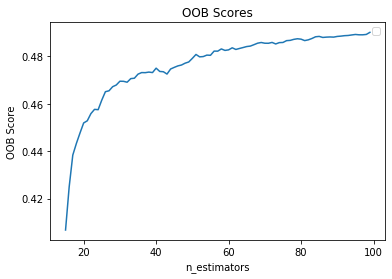

In [57]:
scores = []
valid = []
train = []
for est in range(15,100):
  rf = RandomForestRegressor(
      n_estimators=est,
      min_samples_leaf = 4,
      max_features = 0.4,
      oob_score = True,
      random_state = 42)
  rf.fit(X_train, y_train)
  train.append(rmse(rf.predict(X_train), y_train))
  valid.append(rmse(rf.predict(X_valid), y_valid))
  scores.append(rf.oob_score_)
plt.plot(range(15,100), scores)
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('OOB Score')
plt.title('OOB Scores')

Text(0.5, 1.0, 'Training RMSLE')

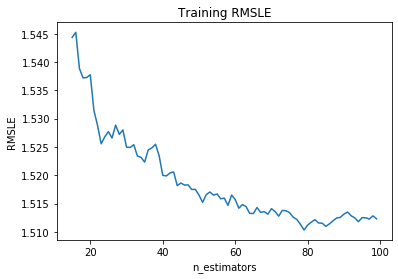

In [58]:
plt.plot(range(15,100), train)
plt.xlabel("n_estimators")
plt.ylabel("RMSLE")
plt.title("Training RMSLE")

Text(0.5, 1.0, 'Validation RMSLE')

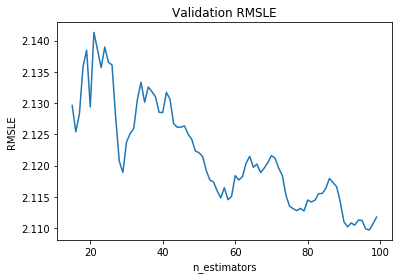

In [59]:
plt.plot(range(15,100), valid)
plt.xlabel("n_estimators")
plt.ylabel("RMSLE")
plt.title("Validation RMSLE")

In [60]:
rf = RandomForestRegressor(
      n_estimators= 55,
      min_samples_leaf = 5,
      max_features = 0.3,
      oob_score = True,
      random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=55,
                      n_jobs=None, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [61]:
print_rf_score(rf)
rf.oob_score_

Train R2:   0.7079180713589741
Valid R2:   0.5045315102024543
Train RMSE: 1.6549752112149994
Valid RMSE: 2.135326251978856


0.4795152924149919

In [0]:
predictions = np.expm1(rf.predict(rf_test))
submission['revenue'] = np.round(predictions)
submission.to_csv('submission_simple_rf.csv', index = False)


In [0]:
# np.expm1(rf.predict(X_valid))[0:20]
# submission['pred'] = np.round(np.expm1(rf.predict(X_valid)))
# submission['actual'] = y_valid

In [64]:
np.expm1(y_valid)

1801     9247881.0
1190           7.0
1817       33700.0
251     10017322.0
2505     8910819.0
           ...    
2497    41954997.0
787       253527.0
2636    67918658.0
2538    15000000.0
402         8251.0
Name: revenue, Length: 300, dtype: float64

In [0]:
def xgtrain(X_train, X_valid, y_train, y_valid):
    regressor = XGBRegressor(
        n_estimators = 50000, 
        learning_rate = 0.001,
        max_depth = 6, 
        subsample = 0.3, 
        colsample_bytree = 0.2
        )
    
    regressor_ = regressor.fit(
        X_train.values, y_train.values, 
        eval_metric = 'rmse', 
        eval_set = [
            (X_train.values, y_train.values), 
            (X_valid.values, y_valid.values)
        ],
        verbose = 1000,
        early_stopping_rounds = 500,
        )
    
    return regressor_

In [66]:
regressor_ = xgtrain(X_train, X_valid, y_train, y_valid)


[22:30:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15.7165	validation_1-rmse:16.0153
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:6.23061	validation_1-rmse:6.39952
[2000]	validation_0-rmse:3.05153	validation_1-rmse:3.17878
[3000]	validation_0-rmse:2.17541	validation_1-rmse:2.33118
[4000]	validation_0-rmse:1.94648	validation_1-rmse:2.14965
[5000]	validation_0-rmse:1.85223	validation_1-rmse:2.10569
[6000]	validation_0-rmse:1.78987	validation_1-rmse:2.09117
[7000]	validation_0-rmse:1.73876	validation_1-rmse:2.08401
[8000]	validation_0-rmse:1.69216	validation_1-rmse:2.08036
[9000]	validation_0-rmse:1.65037	validation_1-rmse:2.07758
[10000]	validation_0-rmse:1.61016	validation_1-rmse:2.07559
Stopping. Best iteration:
[10339]	validation_0-rmse:1.59743	valida

In [0]:
predictions = np.expm1(regressor_.predict(rf_test.values))
submission['revenue'] = np.round(predictions)
submission.to_csv('submission_simple_rf.csv', index = False)

In [0]:
predictions = np.expm1(regressor_.predict(rf_test.values)) + np.expm1(rf.predict(rf_test))
predictions /= 2
submission['revenue'] = np.round(predictions)
submission.to_csv('submission_simple_rf.csv', index = False)